In [3]:
!pip install wheel imutils opencv-python scikit-image

  Using cached https://files.pythonhosted.org/packages/b5/94/46dcae8c061e28be31bcaa55c560cb30ee9403c9a4bb2659768ec1b9eb7d/imutils-0.5.3.tar.gz
  Created wheel for imutils: filename=imutils-0.5.3-cp37-none-any.whl size=25850 sha256=4b5d9438995af89afb1dc1ec9d63dd45fb312d7796f2fcbea1919f5dfd4842f1
  Stored in directory: /home/vin/.cache/pip/wheels/16/84/1f/bf88641293cda2c8be81a5c4b8ca973dd9125a6dc3767417fd
Successfully built imutils


In [2]:
# import the necessary packages
from pyimagesearch.transform import four_point_transform
from skimage.filters import threshold_local
import numpy as np
import argparse
import cv2
import imutils
from IPython.display import Markdown, display
# Imports the Google Cloud client library
from google.cloud import vision
from google.cloud.vision import types
import io
from matplotlib import pyplot as plt
from enum import Enum
import requests
from PIL import Image, ImageEnhance, ImageDraw
from io import BytesIO
from time import sleep

In [360]:
import requests
from PIL import Image, ImageEnhance 
from io import BytesIO
from time import sleep

# To allow me time to grab my phone and aim it at something
sleep(3)

r = requests.get('http://192.168.1.105:8080/photo.jpg')
i = Image.open(BytesIO(r.content))
i

ConnectionError: HTTPConnectionPool(host='192.168.1.105', port=8080): Max retries exceeded with url: /photo.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f29c5727210>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [12]:
# load the image and compute the ratio of the old height
# to the new height, clone it, and resize it
image = cv2.imread('./images/loremipsum.jpg')
height = 2000
ratio = image.shape[0] / 2000.0
# ratio = 2
orig = image.copy()
image = imutils.resize(image, height = 1000)
i = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

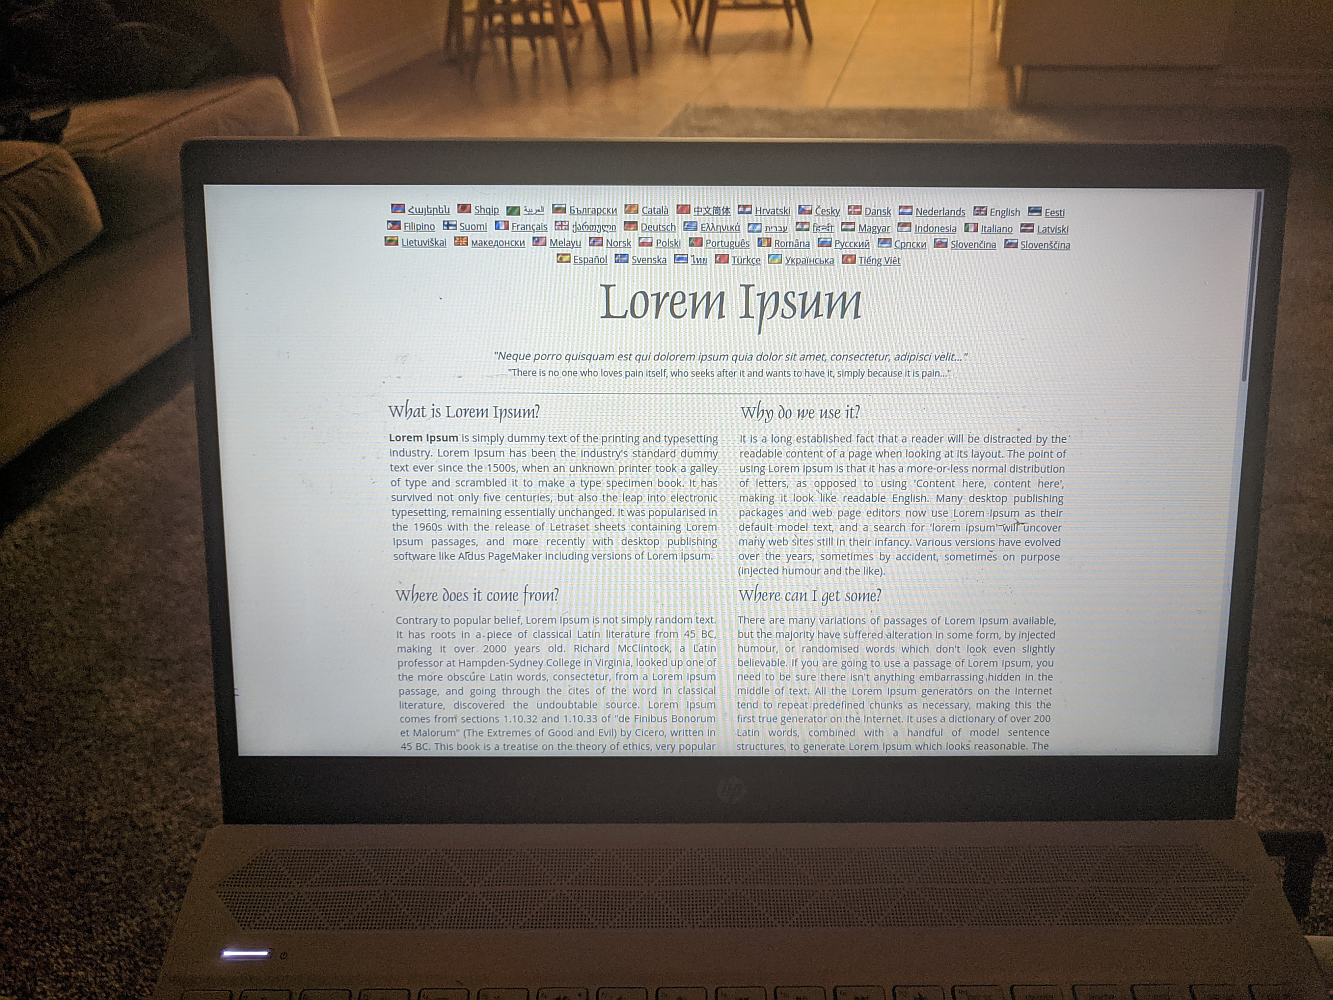

In [13]:
enhancer = ImageEnhance.Sharpness(i)

enhanced_im = enhancer.enhance(2)

enhancer = ImageEnhance.Contrast(enhanced_im)

# enhanced_im = enhancer.enhance(1.5)

enhanced_im

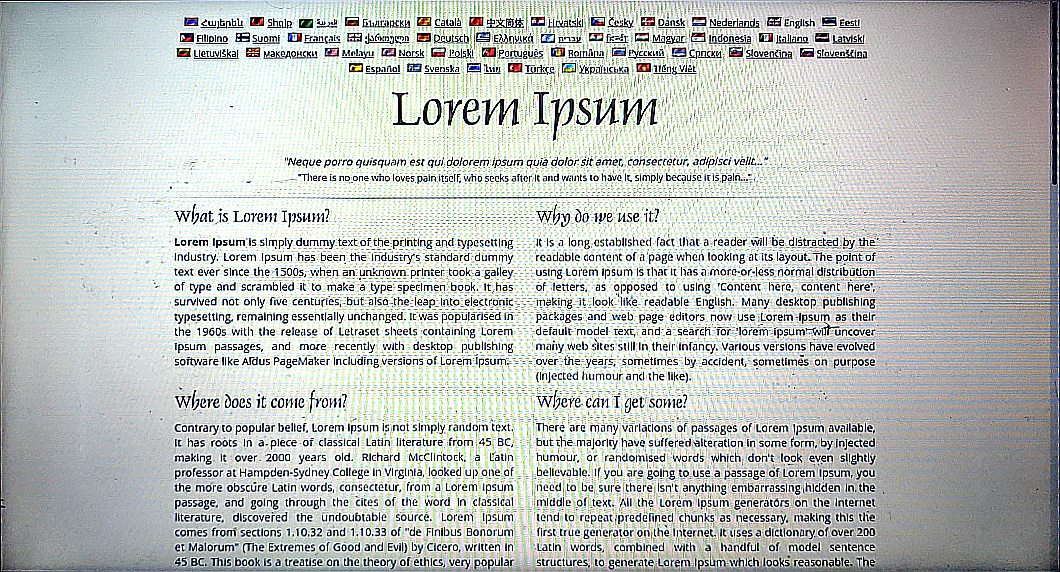

In [14]:
image = cv2.cvtColor(np.array(enhanced_im), cv2.COLOR_RGB2BGR)

# ratio = image.shape[0] / 500.0
orig = image.copy()
# image = imutils.resize(image, height = 500)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)

cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

for c in cnts:
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)

	if len(approx) == 4:
		screenCnt = approx
		break

warped = four_point_transform(orig, screenCnt.reshape(4, 2))

im_pil = Image.fromarray(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
post_enhancer = ImageEnhance.Sharpness(im_pil)

post_im = post_enhancer.enhance(5)

post_enhancer = ImageEnhance.Contrast(post_im)

post_im = post_enhancer.enhance(2)

post_im.save('temp.jpg')

post_im

In [16]:
# Instantiates a client
client = vision.ImageAnnotatorClient.from_service_account_json(
        'client_account_conf.json')

# # The name of the image file to annotate
# file_name = os.path.abspath('resources/wakeupcat.jpg')

# # Loads the image into memory
# with io.open(file_name, 'rb') as image_file:
#     content = image_file.read()

buffer = io.BytesIO()
post_im.save(buffer, "JPEG")
content = buffer.getvalue()

vision_image = types.Image(content=content)

# Performs label detection on the image file
response = client.document_text_detection(image=vision_image)
text = response.text_annotations[0].description
print(text)

El <witabu
Filipino
Lietuviškai
SLOTT
shule z a franckh català xos llevatski fuky Dansk Nederlands English Eesti
suomi Français franyern Deutsch Ennyird
O k Magyar Indonesia tallano Latviski
yakeAOHCKL Melayu Norsk Polski w Português Romina CCMA Concu slovenčina Slovensko
Español - Svenska u Turkce a paliska eng VIEL
Lorem Ipsum
"Neque porro quisquam est qui dolorem ipsum quia dolor sit amet, consectetur, adipisci velit.
"There is no one who loves.pain itself, who secks after it and wants to have it simply because it is pale.....
What is Lorem Ipsum?
Why do we use it?
Lorem Ipsum is slmply dummy text of the printing and typesetting is a long established fact that a reader will be distracted by the
Industry. Lorem Ipsum has been the Industry's standard dummy creadable content of a page when looking at its layout. The point of
text ever since the 1500s, when an unknown printer took a galley using Lorem Ipsum is that it has a more-or-less normal distribution
of type and scrambled it to ma

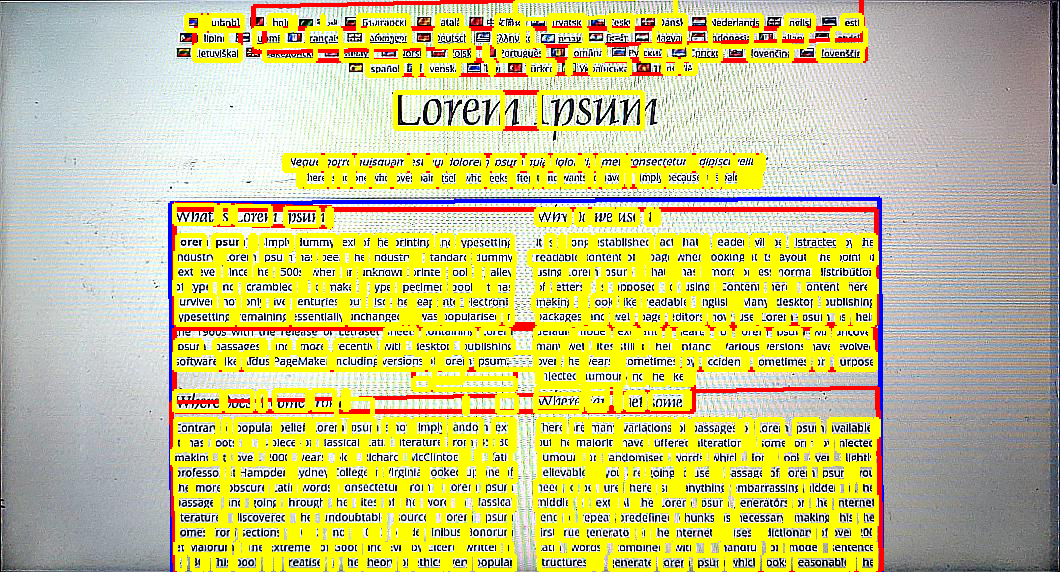

In [18]:
class FeatureType(Enum):
    PAGE = 1
    BLOCK = 2
    PARA = 3
    WORD = 4
    SYMBOL = 5

def draw_boxes(pil_image, bounds, color):
    """Draw a border around the image using the hints in the vector list."""
    draw = ImageDraw.Draw(pil_image)
    line_width = 2
    for bound in bounds:
        draw.line((bound.vertices[0].x, bound.vertices[0].y,
                bound.vertices[3].x, bound.vertices[3].y), color, line_width)
        for i in range(3):
            draw.line((bound.vertices[i].x, bound.vertices[i].y,
                bound.vertices[i+1].x, bound.vertices[i+1].y), color, line_width)
#         draw.polygon([
#             bound.vertices[0].x, bound.vertices[0].y,
#             bound.vertices[1].x, bound.vertices[1].y,
#             bound.vertices[2].x, bound.vertices[2].y,
#             bound.vertices[3].x, bound.vertices[3].y], None, color)
    return image


def get_document_bounds(content, feature):
    """Returns document bounds given an image."""
    global client

    bounds = []

    image = types.Image(content=content)

    response = client.document_text_detection(image=image)
    document = response.full_text_annotation

    # Collect specified feature bounds by enumerating all document features
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    for symbol in word.symbols:
                        if (feature == FeatureType.SYMBOL):
                            bounds.append(symbol.bounding_box)

                    if (feature == FeatureType.WORD):
                        bounds.append(word.bounding_box)

                if (feature == FeatureType.PARA):
                    bounds.append(paragraph.bounding_box)

            if (feature == FeatureType.BLOCK):
                bounds.append(block.bounding_box)

        if (feature == FeatureType.PAGE):
            bounds.append(block.bounding_box)

    # The list `bounds` contains the coordinates of the bounding boxes.
    return bounds


def render_doc_text(content, fileout):
    image = Image.open(BytesIO(content))
    bounds = get_document_bounds(content, FeatureType.PAGE)
    draw_boxes(image, bounds, 'blue')
    bounds = get_document_bounds(content, FeatureType.PARA)
    draw_boxes(image, bounds, 'red')
    bounds = get_document_bounds(content, FeatureType.WORD)
    draw_boxes(image, bounds, 'yellow')
#     bounds = get_document_bounds(content, FeatureType.SYMBOL)
#     draw_boxes(image, bounds, 'green')

    if fileout != 0:
        image.save(fileout)
    else:
        return image

render_doc_text(content, 0)

In [335]:
!ocrmypdf --image-dpi=400 temp.jpg temp.pdf

   INFO - Input file is not a PDF, checking if it is an image...
   INFO - Input file is an image
   INFO - Input image has no ICC profile, assuming sRGB
   INFO - Image seems valid. Try converting to PDF...
   INFO - Successfully converted to PDF, processing...
Scan: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 614.73page/s]
   INFO - Using Tesseract OpenMP thread limit 4
WARNING -    1: [tesseract] lots of diacritics - possibly poor OCR              
OCR: 100%|██████████████████████████████████| 1.0/1.0 [00:04<00:00,  4.23s/page]
JPEGs: 0image [00:00, ?image/s]
JBIG2: 0item [00:00, ?item/s]
   INFO - Optimize ratio: 1.00 savings: 0.0%
   INFO - Output file is a PDF/A-2B (as expected)
